In [80]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import numpy as np
import random
import pickle as pkl

import matplotlib.pyplot as plt

In [81]:
dataset = pd.read_csv('DataTrainingCopy.csv')
y_train = dataset['target']
x_train = dataset.drop(labels =['target'],axis=1)

ohe = OneHotEncoder()
le = LabelEncoder()

cols = x_train.columns.values
for col in cols:
    x_train[col] = le.fit_transform(x_train[col])

y_train = le.fit_transform(y_train)

ohe = OneHotEncoder()
x_train = ohe.fit_transform(x_train).toarray()
sc = StandardScaler()
x_train = sc.fit_transform(x_train)


x_train, x_test, y_train, y_test = train_test_split(x_train,y_train, test_size = 0.30, random_state = 42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test,y_test, test_size = 0.50, random_state = 42)

In [82]:
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

def relu(x):
    return np.maximum(0, x)

def forward(x, w, activation):
    return activation(np.matmul(x, w))

def accuracy_fn(y, y_hat):
    return (np.where(y == y_hat)[0].size / y_hat.size)

def predict(x, y_hat, weights, activation):
    predictions = np.zeros(shape=(x.shape[0]))
    
    for idx in range(x.shape[0]):
        r1 = x[idx, :]
        for curr_weights in weights:
            r1 = forward(r1, curr_weights, activation)
        predictions[idx] = np.where(r1 == np.max(r1))[0][0]

    accuracy = accuracy_fn(predictions, y_hat)
    return accuracy, predictions
    
def fitness(x, y_hat, weights, activation):
    accuracy = np.empty(shape=(weights.shape[0]))
    for idx in range(weights.shape[0]):
        accuracy[idx], _ = predict(x, y_hat, weights[idx, :], activation)
    return accuracy

In [83]:
def mat_to_vector(mat_pop_weights):
    weights_vector = []
    for idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = np.reshape(mat_pop_weights[idx, layer_idx], newshape=(mat_pop_weights[idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        weights_vector.append(curr_vector)
    return np.array(weights_vector)


def vector_to_mat(vector_weights, mat_pop_weights):
    mat_weights = []
    for idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[idx, layer_idx].size
            curr_vector = vector_weights[idx, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

In [84]:
def mating_pool(pop, fitness, num_parents):
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99
    return parents


def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint32(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
        
    return offspring


def mutation(offspring_crossover, mutation_percent):
    num_mutations = np.uint32((mutation_percent*offspring_crossover.shape[1]))
    mutation_indices = np.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))
    
    for idx in range(offspring_crossover.shape[0]):
        random_value = np.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value
    
    return offspring_crossover

In [85]:
solution_per_population = 8
num_parents_mating = 4
num_generations = 100
mutation_percent = 0.20

In [86]:
input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

In [87]:
initial_weights = []
for curr_sol in np.arange(0, solution_per_population):
    
    w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))

    initial_weights.append(np.array([w1]))

In [88]:
weights_mat = np.array(initial_weights)
weights_vector = mat_to_vector(weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

In [89]:
for generation in tqdm(range(num_generations)):

    # vector to matrix
    weights_mat = vector_to_mat(weights_vector, weights_mat)

    # fitness of the population
    fit = fitness(x_train, y_train, weights_mat, activation=sigmoid)
    
    # assign first fitness to the array
    accuracies[generation] = fit[0]

    # selecting mating parents from pool
    parents = mating_pool(weights_vector, fit.copy(), num_parents_mating)

    # generate new population using crossover
    offspring_crossover = crossover(parents, offspring_size=(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1]))

    # adding mutation to the population
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)
    
    # new population combining parents of crossver and mut
    weights_vector[0:parents.shape[0], :] = parents
    weights_vector[parents.shape[0]:, :] = offspring_mutation

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]


In [90]:
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_train, y_train, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  0.17732558139534885


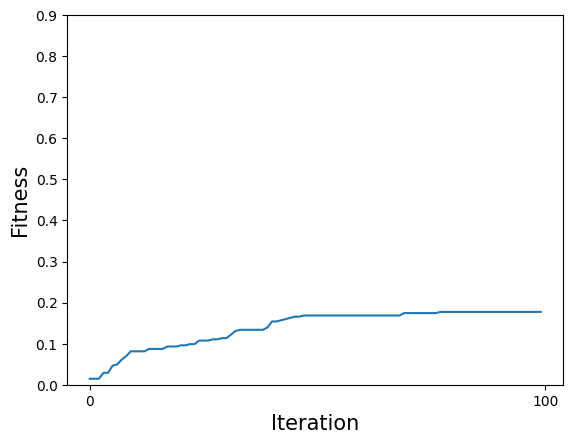

In [91]:
plt.plot(accuracies)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.xticks(np.arange(0, num_generations+1, 100))
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

In [92]:
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_test, y_test, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  0.0945945945945946
